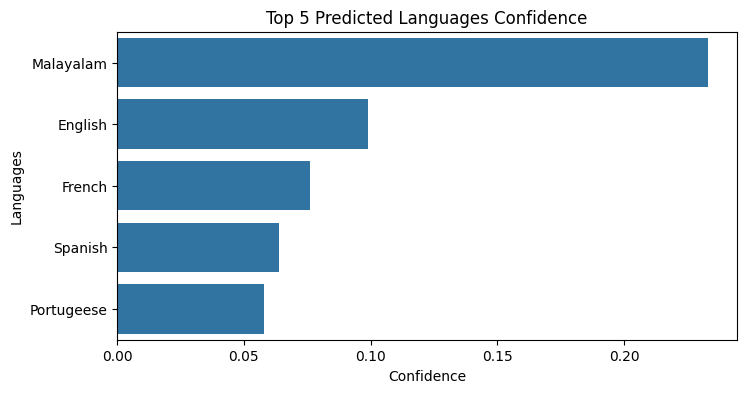

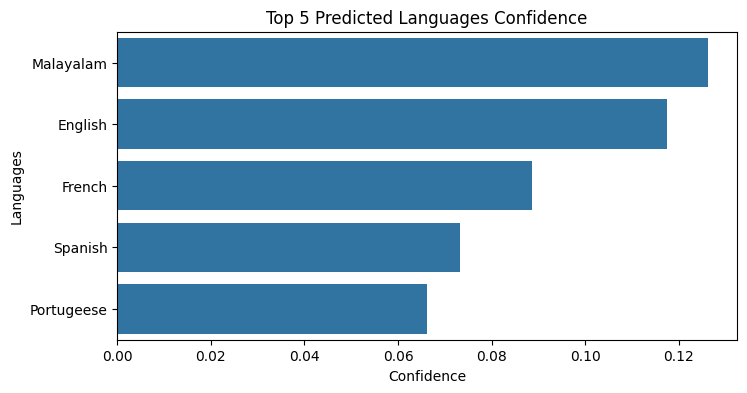

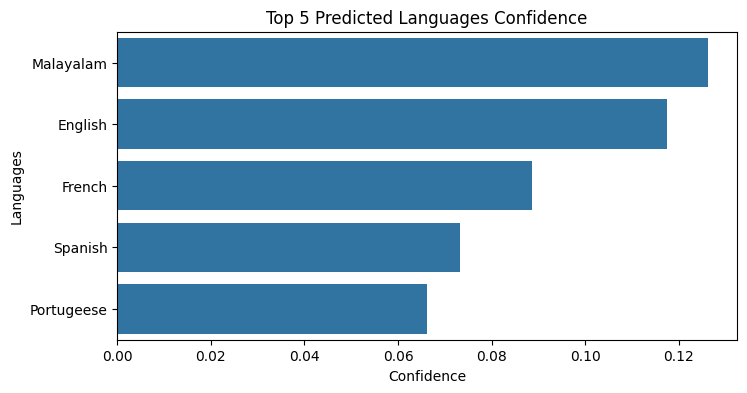

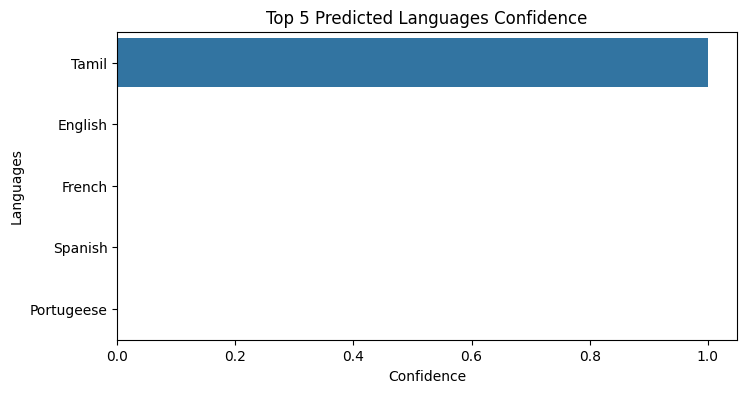

In [1]:
import pandas as pd
import re
import warnings
import tkinter as tk
from tkinter import messagebox, filedialog, scrolledtext
from googletrans import Translator
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns

warnings.simplefilter("ignore")

# Load dataset
data = pd.read_csv("Language Detection.csv")

# Prepare data
X = data["Text"]
y = data["Language"]

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Preprocess text data
def preprocess_text(text):
    text = re.sub(r'[!@#$(),n"%^*?:;~`0-9]', ' ', text)
    text = re.sub(r'[[]]', ' ', text)
    text = text.lower()
    return text

data_list = [preprocess_text(text) for text in X]

# Convert text data to TF-IDF feature vectors
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data_list).toarray()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Train model
model = MultinomialNB()
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)

# Evaluate model
ac = accuracy_score(y_test, y_pred)

# Define prediction function
def predict(text):
    x = tfidf.transform([text]).toarray()  # Convert text to TF-IDF vector
    lang = model.predict(x)  # Predict the language
    lang_proba = model.predict_proba(x)  # Get prediction probabilities
    lang = le.inverse_transform(lang)  # Find the language corresponding to the predicted value
    return lang[0], lang_proba

# Define translation function
def translate_text(text, target_lang):
    translator = Translator()
    translation = translator.translate(text, dest=target_lang)
    return translation.text

# GUI Application
class LanguageDetectionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Language Detection and Translation App")
        self.root.geometry("900x700")
        self.default_bg = "#0a043c"
        self.default_fg = "#61dafb"
        self.root.config(bg=self.default_bg)

        # Create a canvas and a vertical scrollbar to scroll the frame
        self.canvas = tk.Canvas(root, bg=self.default_bg)
        self.scrollbar = tk.Scrollbar(root, orient="vertical", command=self.canvas.yview)
        self.canvas.configure(yscrollcommand=self.scrollbar.set)

        # Create a frame inside the canvas
        self.main_frame = tk.Frame(self.canvas, bg=self.default_bg)

        # Create window inside canvas to contain the frame
        self.canvas.create_window((0, 0), window=self.main_frame, anchor="nw")

        self.main_frame.bind(
            "<Configure>",
            lambda e: self.canvas.configure(
                scrollregion=self.canvas.bbox("all")
            )
        )

        self.canvas.pack(side="left", fill="both", expand=True)
        self.scrollbar.pack(side="right", fill="y")

        # Input Frame
        input_frame = tk.Frame(self.main_frame, bg=self.default_bg)
        input_frame.pack(pady=20)
        
        self.label = tk.Label(input_frame, text="Enter Text to Predict Language:", font=("Helvetica", 16), bg=self.default_bg, fg=self.default_fg)
        self.label.pack(padx=10, pady=10)
        
        self.text_input = scrolledtext.ScrolledText(input_frame, width=50, height=10, font=("Helvetica", 14))
        self.text_input.pack(padx=10, pady=10)
        
        self.predict_button = tk.Button(input_frame, text="Predict", command=self.predict_language, font=("Helvetica", 14), bg=self.default_fg, fg=self.default_bg)
        self.predict_button.pack(pady=10)
        
        # Output Frame
        output_frame = tk.Frame(self.main_frame, bg=self.default_bg)
        output_frame.pack(pady=20)
        
        self.result_label = tk.Label(output_frame, text="Predicted Language: ", font=("Helvetica", 16), bg=self.default_bg, fg=self.default_fg)
        self.result_label.pack(padx=10, pady=10)
        
        self.translate_label = tk.Label(output_frame, text="Enter Text to Translate:", font=("Helvetica", 16), bg=self.default_bg, fg=self.default_fg)
        self.translate_label.pack(padx=10, pady=10)
        
        self.translate_input = scrolledtext.ScrolledText(output_frame, width=50, height=10, font=("Helvetica", 14))
        self.translate_input.pack(padx=10, pady=10)
        
        self.translate_button = tk.Button(output_frame, text="Translate", command=self.translate_language, font=("Helvetica", 14), bg=self.default_fg, fg=self.default_bg)
        self.translate_button.pack(pady=10)
        
        self.translation_result_label = tk.Label(output_frame, text="Translated Text: ", font=("Helvetica", 16), bg=self.default_bg, fg=self.default_fg)
        self.translation_result_label.pack(padx=10, pady=10)
        
        self.translation_text = scrolledtext.ScrolledText(output_frame, width=80, height=10, font=("Helvetica", 14))
        self.translation_text.pack(padx=10, pady=10)
        
        # Model Accuracy
        self.accuracy_label = tk.Label(self.main_frame, text=f"Model Accuracy: {ac*100:.2f}%", font=("Helvetica", 14), bg=self.default_bg, fg=self.default_fg)
        self.accuracy_label.pack(pady=10)

        # File Menu
        menubar = tk.Menu(root)
        file_menu = tk.Menu(menubar, tearoff=0)
        file_menu.add_command(label="Open", command=self.load_text)
        file_menu.add_command(label="Save", command=self.save_text)
        file_menu.add_separator()
        file_menu.add_command(label="Exit", command=root.quit)
        menubar.add_cascade(label="File", menu=file_menu)

        # Help Menu
        help_menu = tk.Menu(menubar, tearoff=0)
        help_menu.add_command(label="Documentation", command=self.show_documentation)
        help_menu.add_command(label="About", command=self.show_about)
        menubar.add_cascade(label="Help", menu=help_menu)

        # Theme Menu
        theme_menu = tk.Menu(menubar, tearoff=0)
        theme_menu.add_command(label="Default", command=lambda: self.apply_theme(self.default_bg, self.default_fg))
        theme_menu.add_command(label="White", command=lambda: self.apply_theme("white", "black"))
        theme_menu.add_command(label="Black", command=lambda: self.apply_theme("black", "white"))
        menubar.add_cascade(label="Themes", menu=theme_menu)

        root.config(menu=menubar)

        # Language selection for translation
        self.languages = {
            'English': 'en', 
            'Hindi': 'hi', 
            'Spanish': 'es', 
            'French': 'fr', 
            'German': 'de', 
            'Italian': 'it', 
            'Malayalam': 'ml', 
            'Tamil': 'ta'
        }

        self.target_lang = tk.StringVar(value='Hindi')

        tk.Label(output_frame, text="Translate to Language:", font=("Helvetica", 14), bg=self.default_bg, fg=self.default_fg).pack(pady=5)
        tk.OptionMenu(output_frame, self.target_lang, *self.languages.keys()).pack(pady=5)

    def predict_language(self):
        text = self.text_input.get("1.0", tk.END).strip()
        if text == "":
            messagebox.showwarning("Input Error", "Please enter some text to predict the language.")
        else:
            predicted_language, lang_proba = predict(text)
            self.result_label.config(text=f"Predicted Language: {predicted_language}")
            self.translate_input.delete("1.0", tk.END)
            self.translate_input.insert("1.0", text)
            self.translation_text.delete("1.0", tk.END)
            self.plot_confidence(lang_proba)

    def translate_language(self):
        text = self.translate_input.get("1.0", tk.END).strip()
        target_lang = self.languages[self.target_lang.get()]
        translated_text = translate_text(text, target_lang)
        self.translation_text.delete("1.0", tk.END)
        self.translation_text.insert(tk.END, translated_text)

    def load_text(self):
        file_path = filedialog.askopenfilename(defaultextension=".txt", filetypes=[("Text files", "*.txt"), ("All files", "*.*")])
        if file_path:
            with open(file_path, "r", encoding="utf-8") as file:
                text = file.read()
                self.text_input.delete("1.0", tk.END)
                self.text_input.insert(tk.END, text)
                self.translate_input.delete("1.0", tk.END)
                self.translate_input.insert(tk.END, text)

    def save_text(self):
        text = self.translation_text.get("1.0", tk.END).strip()
        if text:
            file_path = filedialog.asksaveasfilename(defaultextension=".txt", filetypes=[("Text files", "*.txt"), ("All files", "*.*")])
            if file_path:
                with open(file_path, "w", encoding="utf-8") as file:
                    file.write(text)
                messagebox.showinfo("Save Successful", "File saved successfully.")
        else:
            messagebox.showwarning("Save Error", "No text to save.")

    def apply_theme(self, bg_color, fg_color):
        self.root.config(bg=bg_color)
        self.canvas.config(bg=bg_color)
        self.main_frame.config(bg=bg_color)
        
        self.label.config(bg=bg_color, fg=fg_color)
        self.text_input.config(bg=bg_color, fg=fg_color, insertbackground=fg_color)
        self.predict_button.config(bg=fg_color, fg=bg_color)
        
        self.result_label.config(bg=bg_color, fg=fg_color)
        self.translate_label.config(bg=bg_color, fg=fg_color)
        self.translate_input.config(bg=bg_color, fg=fg_color, insertbackground=fg_color)
        self.translate_button.config(bg=fg_color, fg=bg_color)
        self.translation_result_label.config(bg=bg_color, fg=fg_color)
        self.translation_text.config(bg=bg_color, fg=fg_color, insertbackground=fg_color)
        self.accuracy_label.config(bg=bg_color, fg=fg_color)
        
        for widget in self.main_frame.winfo_children():
            if isinstance(widget, tk.Label):
                widget.config(bg=bg_color, fg=fg_color)
            elif isinstance(widget, tk.Button):
                widget.config(bg=fg_color, fg=bg_color)

        input_frame = self.main_frame.winfo_children()[0]
        output_frame = self.main_frame.winfo_children()[1]
        
        input_frame.config(bg=bg_color)
        output_frame.config(bg=bg_color)
        for widget in input_frame.winfo_children():
            if isinstance(widget, tk.Label):
                widget.config(bg=bg_color, fg=fg_color)
            elif isinstance(widget, tk.Button):
                widget.config(bg=fg_color, fg=bg_color)
        for widget in output_frame.winfo_children():
            if isinstance(widget, tk.Label):
                widget.config(bg=bg_color, fg=fg_color)
            elif isinstance(widget, tk.Button):
                widget.config(bg=fg_color, fg=bg_color)
            elif isinstance(widget, tk.OptionMenu):
                widget.config(bg=bg_color, fg=fg_color)

    def plot_confidence(self, lang_proba):
        fig, ax = plt.subplots(figsize=(8, 4))
        top_lang_proba = sorted(zip(le.classes_, lang_proba[0]), key=lambda x: x[1], reverse=True)[:5]
        languages, probabilities = zip(*top_lang_proba)
        sns.barplot(x=probabilities, y=languages, ax=ax)
        ax.set_title("Top 5 Predicted Languages Confidence")
        ax.set_xlabel("Confidence")
        ax.set_ylabel("Languages")

        for widget in self.main_frame.winfo_children():
            if isinstance(widget, FigureCanvasTkAgg):
                widget.get_tk_widget().pack_forget()

        canvas = FigureCanvasTkAgg(fig, master=self.main_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(pady=10)


    def show_documentation(self):
        documentation = (
            "Language Detection and Translation App\n\n"
            "1. Enter the text you want to predict the language for in the input box.\n"
            "2. Click on the 'Predict' button to see the predicted language.\n"
            "3. Enter the text you want to translate in the 'Enter Text to Translate' box.\n"
            "4. Select the target language from the dropdown menu.\n"
            "5. Click on the 'Translate' button to see the translated text.\n"
            "6. Use the 'File' menu to open or save text files.\n"
            "7. Use the 'Help' menu for documentation or information about the app.\n"
            "8. Use the 'Themes' menu to switch between different themes.\n"
        )
        messagebox.showinfo("Documentation", documentation)

    def show_about(self):
        about_text = (
            "Language Detection and Translation App\n\n"
            "Version: 1.0\n"
            "Author: Abin Pillai\n\n"
            "This app uses a Multinomial Naive Bayes model trained on a dataset of text samples to predict the language of a given text. "
            "It also provides translation functionality using the Google Translate API."
        )
        messagebox.showinfo("About", about_text)

if __name__ == "__main__":
    root = tk.Tk()
    app = LanguageDetectionApp(root)
    root.mainloop()
